# Calmodulin Final Analysis

This notebook contains all of the analysis, figure generation, and detailed explanations for the calmodulin dataset. 

tICA distance and MFPT was used as a "golden" standard metric to compare our methods to the MSM, our gold standard.

tICA between each structure was computed by using MSMBuilder. In this series of plots, we compare the distance in various spaces (found by ISOMAP, Spectral Embedding, PCA, and raw XYZ) vs the distance in the space found by tICA. 

MFPT was computed using MSMBuilder.

Parameters for presentation: num_frames = 5000, n_neighbors = 2000

In [448]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
import msmbuilder.utils as msmUtils
from msmbuilder.tpt import mfpts
import mdtraj as md
from scipy import ndimage

In [3]:
%matplotlib inline

In [413]:
num_frames = 5000
n_neighbors = 2000

In [398]:
# Import the coordinates of each frame in the tICA space, saved from the MSMBuilder.
base = 'C:\\Users\\minch_000\\Documents\\TJ_data'
tICA_coordinates = np.loadtxt(base + '\\apo_calmodulin\sim_datasets\\tICA_coord_+apo_calmodulin.csv', delimiter=',')

In [414]:
# Import raw dihedral features and corresponding indices
X_dihedral = np.loadtxt(base + r'\apo_calmodulin\sim_datasets\raw_angle_' + str(num_frames) + '.csv', delimiter=',')
indices = np.loadtxt(base + '\\apo_calmodulin\sim_datasets\\indices_' + str(num_frames) + '.csv', delimiter=',').astype(int)

#### Compute Spectral Embedding and PCA

In [494]:
pca = PCA(n_components=2)
X_pc = pca.fit_transform(X_dihedral)
se = manifold.SpectralEmbedding(n_neighbors=n_neighbors, n_components=3)
X_se = pca.fit_transform(se.fit_transform(X_dihedral))
#X_se = se.fit_transform(X_dihedral)

In [ ]:
X_iso 

#### tICA distance vs dihedral/PCA/Spectral Embedding

Dihedral distance serves as the baseline. PCA on raw dihedral angles and Spectral Embedding.

In [495]:
# Function for plotting various distance vs tICA
def plot_against_tICA(tx, x, indices, num_points=100):
    xdist = []
    txdist = []
    for p in range(num_points):
        frame_pair = np.random.randint(low=0, high=x.shape[0]-1, size=2) # frame number in sim_data
        xdist.append(np.linalg.norm(x[frame_pair[0],:] - x[frame_pair[1], :]))
        txdist.append(np.linalg.norm(tx[indices[frame_pair[0]],:] - tx[indices[frame_pair[1]], :]))
    plt.scatter(xdist, txdist)

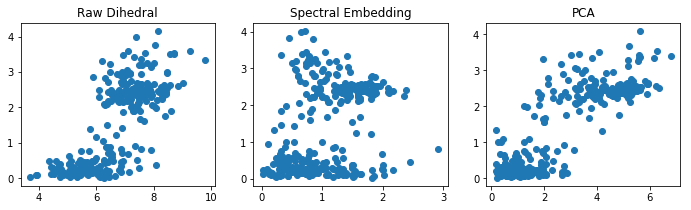

In [496]:
plt.figure(figsize=(4*4, 3))
plt.subplot(1, 4, 1)
plot_against_tICA(tICA_coordinates[:, 0:2], X_dihedral, indices, 300);plt.title('Raw Dihedral')
plt.subplot(1, 4, 2)
plot_against_tICA(tICA_coordinates[:, 0:2], X_se, indices, 300);plt.title('Spectral Embedding')
plt.subplot(1, 4, 3)
plot_against_tICA(tICA_coordinates[:, 0:2], X_pc, indices, 300);plt.title('PCA')

#### MFPT vs dihedral/PCA/Spectral Embedding

Dihedral distance serves as the baseline. PCA on raw dihedral angles and Spectral Embedding.

In [497]:
# Import MSM files
msm = msmUtils.load(base + r'\apo_calmodulin\sim_datasets\msm_apo_calmodulin.pkl')
sample_cluster_assignments = np.loadtxt(base + r'\apo_calmodulin\sim_datasets\sample_cluster_assignment_' + str(num_frames) + '.csv', delimiter=',')

In [498]:
# Function for plotting various distance vs MFPT
def plot_against_MFPT(msm, x, sample_cluster_assignments, num_points=100):
    xdist = []
    mfpt = []
    mfpt_matrix = mfpts(msm) + mfpts(msm).transpose()
    for p in range(num_points):
        frame_pair = np.random.randint(low=0, high=x.shape[0]-1, size=2) # frame number in sim_data
        msm_frame_pair = (msm.mapping_[sample_cluster_assignments[frame_pair[0]]], msm.mapping_[sample_cluster_assignments[frame_pair[1]]])
        d = np.linalg.norm(x[frame_pair[0],:] - x[frame_pair[1], :], 2)
        m = mfpt_matrix[msm_frame_pair[0]][msm_frame_pair[1]]
        if msm_frame_pair[0] != msm_frame_pair[1] and m < 2000:
            xdist.append(d)
            mfpt.append(np.sqrt(m))
    plt.scatter(xdist, mfpt)

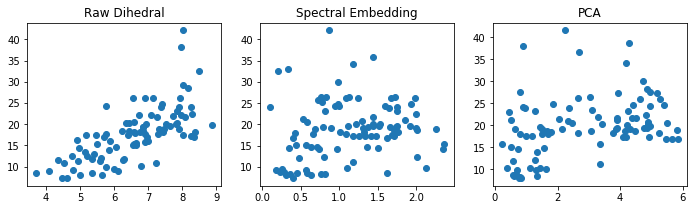

In [499]:
plt.figure(figsize=(4*4, 3))
plt.subplot(1, 4, 1)
num_points = 100
plot_against_MFPT(msm, X_dihedral, sample_cluster_assignments, num_points);plt.title('Raw Dihedral')
plt.subplot(1, 4, 2)
plot_against_MFPT(msm, X_se, sample_cluster_assignments, num_points);plt.title('Spectral Embedding')
plt.subplot(1, 4, 3)
plot_against_MFPT(msm, X_pc, sample_cluster_assignments, num_points);plt.title('PCA')

#### tIC vs Dynamical Directions found by SpectralEmbedding/PCA

The directions found by SpectralEmbedding and PCA are compared against tICs.

In [500]:
# Function for plotting various distance vs MFPT
def plot_against_tICA_comp(tx, x, tx_comp, x_comp, indices, num_indices):
    plt.scatter(x[:num_indices, x_comp], tx[indices[:num_indices], tx_comp])

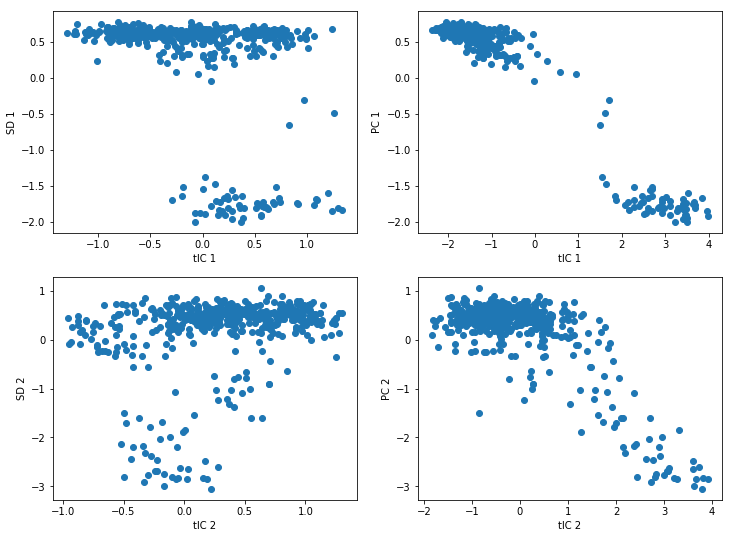

In [501]:
plt.figure(figsize=(4*3, 3*3))
num_points = 500
plt.subplot(2, 2, 1)
plot_against_tICA_comp(tICA_coordinates, X_se, 0, 0, indices, num_points); plt.ylabel('SD 1'); plt.xlabel('tIC 1')
plt.subplot(2, 2, 2)
plot_against_tICA_comp(tICA_coordinates, X_pc, 0, 0, indices, num_points); plt.ylabel('PC 1'); plt.xlabel('tIC 1')
plt.subplot(2, 2, 3)
plot_against_tICA_comp(tICA_coordinates, X_se, 1, 1, indices, num_points); plt.ylabel('SD 2'); plt.xlabel('tIC 2')
plt.subplot(2, 2, 4)
plot_against_tICA_comp(tICA_coordinates, X_pc, 1, 1, indices, num_points); plt.ylabel('PC 2'); plt.xlabel('tIC 2')

#### Energy landscapes

Dynamical directions found by tICA, Spectral Embedding and PCA

In [502]:
def plot_heatmap(X_se):
    x = X_se[:,0]
    y = X_se[:,1]
    xedges, yedges = np.linspace(min(x), max(x), 30), np.linspace(min(y), max(y), 30)
    hist, xedges, yedges = np.histogram2d(X_se[:,0],X_se[:,1],(xedges, yedges))
    #hist = np.log(hist)
    xidx = np.clip(np.digitize(X_se[:,0], xedges), 0, hist.shape[0]-1)
    yidx = np.clip(np.digitize(X_se[:,1], yedges), 0, hist.shape[1]-1)
    c = -np.log(hist[xidx, yidx])
    plt.scatter(X_se[:,0], X_se[:,1], c=c, edgecolor='none', cmap=plt.cm.Spectral)
    cb = plt.colorbar()
    cb.set_label('log10(N)')

C:\Users\minch_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in log


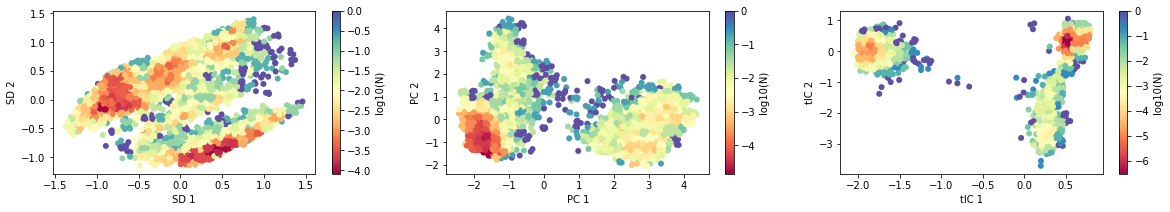

In [503]:
plt.figure(figsize=(4*5, 3*1))
plt.subplot(1, 3, 1)
plot_heatmap(X_se); plt.xlabel('SD 1'); plt.ylabel('SD 2')
plt.subplot(1, 3, 2)
plot_heatmap(X_pc); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.subplot(1, 3, 3)
plot_heatmap(tICA_coordinates[indices,:]); plt.xlabel('tIC 1'); plt.ylabel('tIC 2')

#### Videos sampled along 1st tIC, PC, and Spectral Embedding dimension

These videos are sampled along the dominant dynamical modes found by tICA, PCA, and Spectral Embedding

In [504]:
X_XYZ = np.loadtxt(base + r'\apo_calmodulin\sim_datasets\raw_XYZ_' + str(num_frames) + '.csv', delimiter=',')

In [505]:
def save_traj(traj, filename):
    seq = np.reshape(traj, (traj.shape[0], int(traj.shape[1]/3), 3))
    md_traj = md.Trajectory(seq, md.load(base + r'\apo_calmodulin\1cfd_protein.pdb').topology)
    md_traj.save_xtc(base + r'\apo_calmodulin\videos\\' + filename)

In [506]:
# Sampled along first dimension
direction = tICA_coordinates[indices,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'first_tICA_sample.xtc')
direction = X_se[:,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'first_SE_dim_sample.xtc')
direction = X_pc[:,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'first_PC_sample.xtc')

In [507]:
# Sampled along second dimension
direction = tICA_coordinates[indices,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'second_tICA_sample.xtc')
direction = X_se[:,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'second_SE_dim_sample.xtc')
direction = X_pc[:,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'second_PC_sample.xtc')

#### Calmodulin Specific Analysis - Apo/Holo Transition (Second dominant dynamic process)

The following analysis was inspired by Shukla et al's paper on calmodulin.
We measured the Phe92-Phe141 distance against the first dynamical mode found by PCA/SE/tICA.

In [508]:
phe92_atom = 178
phe141_atom = 912
phe92_idx = range(3*(phe92_atom-1), 3*(phe92_atom-1)+3)
phe141_idx = range(3*(phe141_atom-1), 3*(phe141_atom-1)+3)
phe92_coor = X_XYZ[:, phe92_idx]
phe141_coor = X_XYZ[:, phe141_idx]
dist_92_141 = np.sqrt(np.sum(((phe92_coor-phe141_coor)**2), axis=1))

In [509]:
def smooth(y, box_pts):
#     box = np.ones(box_pts)/box_pts
#     y_smooth = np.convolve(y, box, mode='valid')
    y_smooth = ndimage.filters.gaussian_filter1d(y, box_pts)
    return y_smooth

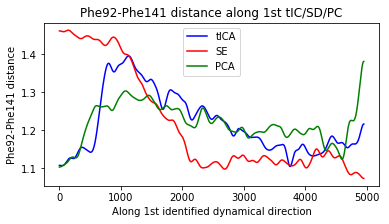

In [516]:
# When sorted by discovered dynamic directions
plt.figure(figsize=(3*2, 3))
idx_tica = tICA_coordinates[indices,1].argsort()[-len(tICA_coordinates[indices,1]):]
plt.plot(smooth(dist_92_141[idx_tica], 50), 'b', label='tICA'); 
plt.title('Phe92-Phe141 distance along 1st tIC/SD/PC')
plt.ylabel('Phe92-Phe141 distance'); plt.xlabel('Along 1st identified dynamical direction')
idx_se = X_se[:,1].argsort()[-len(X_se[:,1]):]#[::-1]
plt.plot(smooth(dist_92_141[idx_se], 50), 'r', label='SE'); 
idx_pc = X_pc[:,1].argsort()[-len(X_pc[:,1]):][::-1]
plt.plot(smooth(dist_92_141[idx_pc], 50), 'g', label='PCA');
plt.legend()

In [511]:
tICA_coordinates[indices, :].shape

(4949, 20)

#### Calmodulin Specific Analysis - Partial Unfolding (Second dominant dynamic process)

The following analysis was inspired by Shukla et al's paper on calmodulin.
We measured the Met124-Ala128 distance against the second dynamical mode found by PCA/SE/tICA.

In [512]:
met124_atom = 660
ala128_atom = 735
met124_idx = range(3*(met124_atom-1), 3*(met124_atom-1)+3)
ala128_idx = range(3*(ala128_atom-1), 3*(ala128_atom-1)+3)
met124_coor = X_XYZ[:, met124_idx]
ala128_coor = X_XYZ[:, ala128_idx]
dist_124_128 = np.sqrt(np.sum(((met124_coor-ala128_coor)**2), axis=1))

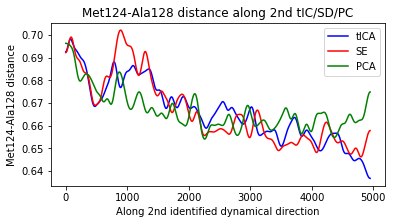

In [517]:
# When sorted by discovered dynamic directions
plt.figure(figsize=(3*2, 3))
idx_tica = tICA_coordinates[indices,1].argsort()[-len(tICA_coordinates[indices,1]):]
plt.plot(smooth(dist_124_128[idx_tica], 50), 'b', label='tICA'); 
plt.title('Met124-Ala128 distance along 2nd tIC/SD/PC')
plt.ylabel('Met124-Ala128 distance');  plt.xlabel('Along 2nd identified dynamical direction')
idx_se = X_se[:,1].argsort()[-len(X_se[:,1]):]#[::-1]
plt.plot(smooth(dist_124_128[idx_se], 50), 'r', label='SE'); 
idx_pc = X_pc[:,1].argsort()[-len(X_pc[:,1]):][::-1]
plt.plot(smooth(dist_124_128[idx_pc], 50), 'g', label='PCA');
plt.legend()

#### Excess code

In [514]:
# plt.figure(figsize=(3*4, 3))
# plt.subplot(1, 3, 1)
# plt.scatter(tICA_coordinates[indices, 0][::5], dist_92_141[::5]); plt.title('Phe92-Phe141 distance vs tIC 1')
# plt.ylabel('Phe92-Phe141 distance')
# plt.gca().invert_xaxis()
# plt.subplot(1, 3, 2)
# plt.scatter(X_se[:, 0][::5], dist_92_141[::5]); plt.title('Phe92-Phe141 distance vs SD 1')
# plt.subplot(1, 3, 3)
# plt.scatter(X_pc[:, 0][::5], dist_92_141[::5]); plt.title('Phe92-Phe141 distance vs PC 1')
# print('For tIC plt, x-axis is inverted for better viewing')

In [515]:
# plt.figure(figsize=(3*4, 3))
# plt.subplot(1, 3, 1)
# plt.scatter(tICA_coordinates[indices, 1][::5], dist_124_128[::5]); plt.title('Met124-Ala128 distance vs tIC 2')
# plt.ylabel('Met124-Ala128 distance')
# plt.gca().invert_xaxis()
# plt.subplot(1, 3, 2)
# plt.scatter(X_se[:, 1][::5], dist_124_128[::5]); plt.title('Met124-Ala128 distance vs SD 2')
# plt.subplot(1, 3, 3)
# plt.scatter(X_pc[:, 1][::5], dist_124_128[::5]); plt.title('Met124-Ala128 distance vs PC 2')
# print('For tIC plt, x-axis is inverted for better viewing')